# This code is developed by Mohit Kumar Soni under the supervision of Dr. Md Masiur Rahaman
###  masiurr@iitbbs.ac.in
### mks14@iitbbs.ac.in

### 1D Beam Problem

#### Importing all the necessary packages

In [1]:
using Flux
using Statistics
using Plots
using CPUTime
using LinearAlgebra

##### Problem to be solved
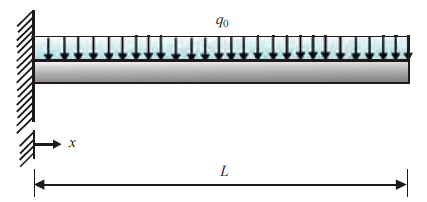
$$
\\Governing \space Equation \\
\frac{d^4(\delta)}{dx^4} = \frac{q}{(EI)} \\
\space Boundary \space Conditions:\\
\delta(0.0) = 0.0\\
\frac{d(\delta)}{dx}(0) = 0.0\\
\frac{d^3(\delta)}{dx^3}(L) = 0.0\\
\frac{d^2(\delta)}{dx^2}(L) = 0.0
$$

### Input Parameteres

In [2]:
L = 2 #m
w = 4000 #N/m
EI = 5*10^6 #N.m2

cons = w/(EI)
dx = 0.025 #discritization
ϵ = dx #small 'h' for differentiation

# Neural Network parameters
dim_input = 1
dim_output = 1
N = 32; # Number of nodes in the hidden layer

### Defining the model for deflection

Chain function is used to create the collection of different layers. In the below Neural Network there are three hidden dense layers which contain N nodes each.

Activation Function "tanh" : - 
Activation functions are used to provide non-linearity in the model. There are several activation functions such as 'ReLU', 'LeakyReLU', 'sigmoid' and 'tan-h'(hyperbolic tangent activation function) etc. the reason behind tanh is that it's range is in between [-1, 1] which provides more better results as compared to the sigmoid activation function.

In [3]:
model = Chain(x -> [x], Dense(dim_input,N,tanh), Dense(N,N,tanh), Dense(N,dim_output), x -> x[1])

Chain(
  var"#1#3"(),
  Dense(1, 32, tanh),                   # 64 parameters
  Dense(32, 32, tanh),                  # 1_056 parameters
  Dense(32, 1),                         # 33 parameters
  var"#2#4"(),
)                   # Total: 6 arrays, 1_153 parameters, 4.879 KiB.

### Defining the required derivatives

In [4]:
d_x(x) = (model.(x .+ ϵ) .- model.(x)) ./ϵ #1st Order derivative of model
d2_x(x) = (d_x.(x .+ ϵ) .- d_x.(x)) ./ ϵ #2rd Order derivative of model
d3_x(x) = (d2_x.(x .+ ϵ) .- d2_x.(x)) ./ ϵ #3rd Order derivative of model
d4_x(x) = (d3_x.(x .+ ϵ) .- d3_x.(x)) ./ ϵ #4th Order derivative of model

d4_x (generic function with 1 method)

### Function to define the governing equation

In [5]:
function Governing_Equation(x)
    return (d4_x(x) .- 1)
end

Governing_Equation (generic function with 1 method)

### Discretization

In [6]:
dom = collect(0.0:dx:L)
z1 = 0;

### Define Loss function

Satisfying boundary conditions and the governing equation at discretized points.

In [7]:
loss1() = sum(norm.((abs2.(Governing_Equation(dom))) .+ abs2.(d3_x.(L) .- z1) .+ abs2.(d2_x.(L) .- z1).+ abs2.(d_x.(z1) .- z1).+ abs2.(model.(z1) .- z1)) .- zeros(length(dom)))

loss1 (generic function with 1 method)

### Define Neural network parameters (ps1) and optimizers to train the model

In [8]:
ps1 = Flux.params(model)
opt1 = Flux.ADAM(0.015)
data1 = Iterators.repeated((),1500)

Base.Iterators.Take{Base.Iterators.Repeated{Tuple{}}}(Base.Iterators.Repeated{Tuple{}}(()), 1500)

#### Define function to train the model

In [9]:
function my_custom_train!(loss, ps, data, opt)
    local training_loss
    itr = 0
    for d in data
        gs = gradient(ps) do
            training_loss = loss()
            if (itr %100 == 0.0)
                print("Current Loss : ",training_loss,"\n")
            end
            return training_loss
        end
        Flux.Optimise.update!(opt, ps, gs)
        itr += 1;
    end
end

my_custom_train! (generic function with 1 method)

#### Train the model

In [10]:
@time @CPUtime my_custom_train!(loss1, ps1, data1, opt1)

Current Loss : 64.09080386326657
Current Loss : 2.7918299753915328
Current Loss : 0.19112312218730024
Current Loss : 0.49593829370357173
Current Loss : 0.08143876198626113
Current Loss : 0.12572416246099002
Current Loss : 0.11810238702974975
Current Loss : 0.5734965471126042
Current Loss : 0.2585091431478742
Current Loss : 0.04425578274771664
Current Loss : 0.10663612106156325
Current Loss : 0.15739022100682282
Current Loss : 0.22149105049307036
Current Loss : 0.10492634146115508
Current Loss : 0.256993684658547
elapsed CPU time: 556.203 seconds
574.271879 seconds (764.06 M allocations: 115.486 GiB, 7.43% gc time, 15.95% compilation time)


### Analytic Solution of the problem

In [11]:
function analytic_solution(x)
    return (cons*(x^4 -4*L*x^3 + (6*L^2)*x^2))/24
end

analytic_solution (generic function with 1 method)

### Ploting and comparing the results

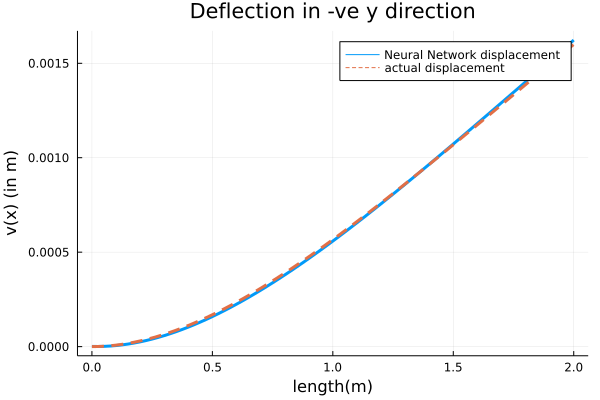

In [12]:
p = plot(dom,cons*model.(dom),linewidth = 3, title = "Deflection in -ve y direction", label = "Neural Network displacement",xaxis="length(m)",yaxis="v(x) (in m)")
p = plot!(dom,analytic_solution.(dom),lw=3,ls=:dash,label = "actual displacement")
savefig("1D_Beam_results.pdf")
plot(p)